In [1]:
# =========================
# Cell 1: Imports + paths + reproducibility (required)
# =========================

import os, re, csv, json, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PROJECT_ROOT = "."
DATA_DIR = os.path.join(PROJECT_ROOT, "Amazon_products")

TRAIN_CORPUS_PATH = os.path.join(DATA_DIR, "train", "train_corpus.txt")
TEST_CORPUS_PATH  = os.path.join(DATA_DIR, "test",  "test_corpus.txt")

CLASSES_PATH = os.path.join(DATA_DIR, "classes.txt")
HIER_PATH    = os.path.join(DATA_DIR, "class_hierarchy.txt")
KEYWORD_PATH = os.path.join(DATA_DIR, "class_related_keywords.txt")

ART_DIR = os.path.join(PROJECT_ROOT, "artifacts_Experiment1")
os.makedirs(ART_DIR, exist_ok=True)

NUM_CLASSES = 531
MIN_LABELS = 2
MAX_LABELS = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [2]:
# =========================
# Cell 2: Clean + Load Corpus
# =========================

TAG_RE = re.compile(r"<[^>]+>")

def clean_text(s: str) -> str:
    s = s or ""
    s = TAG_RE.sub(" ", s)
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_corpus(path: str):
    pid2text = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                pid, text = parts
                pid2text[pid] = clean_text(text)
    return pid2text

pid2text_train = load_corpus(TRAIN_CORPUS_PATH)
pid2text_test  = load_corpus(TEST_CORPUS_PATH)
id_list_test   = list(pid2text_test.keys())

print("train:", len(pid2text_train), "test:", len(pid2text_test))


train: 29487 test: 19658


In [3]:
# =========================
# Cell 3: Load classes (robust) + hierarchy + adjacency matrix A_hat
# =========================

def load_classes(path):
    """
    Supports:
      - 'id<TAB>class name with spaces'
      - OR 'id<space>class name with spaces'
      - OR name-only per line
    """
    name2id, id2name = {}, {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            m = re.match(r"^(\d+)\s+(.+)$", line)
            if m:
                cid = int(m.group(1))
                cname = m.group(2).strip()
            else:
                parts = line.split("\t")
                if len(parts) == 2 and parts[0].isdigit():
                    cid = int(parts[0])
                    cname = parts[1].strip()
                else:
                    cid = len(id2name)
                    cname = line

            name2id[cname] = cid
            id2name[cid] = cname

    return name2id, id2name

name2id, id2name = load_classes(CLASSES_PATH)
assert len(id2name) == NUM_CLASSES, f"Expected {NUM_CLASSES}, got {len(id2name)}"
print("num classes loaded:", len(id2name))

def load_hierarchy(path):
    parents = defaultdict(set)  # child -> parents
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            p_str, c_str = line.split("\t")
            p, c = int(p_str), int(c_str)
            parents[c].add(p)
    return parents

parents = load_hierarchy(HIER_PATH)

def get_ancestors(cid: int) -> list:
    # nearest-first expansion (BFS-ish)
    seen = set()
    q = [cid]
    out = []
    while q:
        x = q.pop(0)
        for p in sorted(list(parents.get(x, []))):
            if p not in seen:
                seen.add(p)
                out.append(p)
                q.append(p)
    return out

def build_label_adj(num_classes, parents_dict, add_self_loop=True, undirected=True):
    A = np.zeros((num_classes, num_classes), dtype=np.float32)
    for child, ps in parents_dict.items():
        for p in ps:
            A[p, child] = 1.0
            if undirected:
                A[child, p] = 1.0
    if add_self_loop:
        np.fill_diagonal(A, 1.0)

    deg = A.sum(axis=1)
    deg_inv_sqrt = np.power(deg, -0.5, where=deg > 0)
    deg_inv_sqrt[deg == 0] = 0.0
    D_inv_sqrt = np.diag(deg_inv_sqrt)
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32)

A_hat = build_label_adj(NUM_CLASSES, parents).to(device)
print("A_hat:", A_hat.shape)


num classes loaded: 531
A_hat: torch.Size([531, 531])


In [4]:
# =========================
# Cell 4: Load class-related keywords (COLON format)
# =========================

def load_class_keywords(path, id2name):
    """
    Format expected:
    class_name:kw1,kw2,kw3,...
    """
    name2id = {v: k for k, v in id2name.items()}
    cid2kws = defaultdict(list)

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue

            cname, rest = line.split(":", 1)
            cname = cname.strip()

            if cname not in name2id:
                # IMPORTANT: this prevents silent bugs
                continue

            cid = name2id[cname]
            kws = [clean_text(k) for k in rest.split(",")]
            kws = [k for k in kws if k]

            cid2kws[cid].extend(kws)

    # de-duplicate keywords per class
    for cid in cid2kws:
        cid2kws[cid] = list(dict.fromkeys(cid2kws[cid]))

    return cid2kws

cid2kws = load_class_keywords(KEYWORD_PATH, id2name)

print("Loaded keyword classes:", len(cid2kws))
print("Example:", id2name[0], cid2kws.get(0, [])[:10])


Loaded keyword classes: 531
Example: grocery_gourmet_food ['snacks', 'condiments', 'beverages', 'specialty_foods', 'spices', 'cooking_oils', 'baking_ingredients', 'gourmet_chocolates', 'artisanal_cheeses', 'organic_foods']


In [5]:
# =========================
# Cell 4a: Ancestor expansion helper (core -> expanded)
# =========================

def load_hierarchy(path):
    parents = defaultdict(set)  # child -> parents
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            p_str, c_str = line.split("\t")
            p, c = int(p_str), int(c_str)
            parents[c].add(p)
    return parents

parents = load_hierarchy(HIER_PATH)

def get_ancestors(cid: int) -> set:
    anc = set()
    stack = [cid]
    while stack:
        x = stack.pop()
        for p in parents.get(x, []):
            if p not in anc:
                anc.add(p)
                stack.append(p)
    return anc

def compute_depths(num_classes: int):
    depth = [-1] * num_classes
    def dfs(x):
        if depth[x] != -1:
            return depth[x]
        ps = parents.get(x, [])
        if not ps:
            depth[x] = 0
            return 0
        depth[x] = 1 + max(dfs(p) for p in ps)
        return depth[x]
    for i in range(num_classes):
        dfs(i)
    return depth

depths = compute_depths(NUM_CLASSES)
print("max depth:", max(depths))

def build_label_adj(num_classes, parents_dict, add_self_loop=True, undirected=True):
    A = np.zeros((num_classes, num_classes), dtype=np.float32)
    for child, ps in parents_dict.items():
        for p in ps:
            A[p, child] = 1.0
            if undirected:
                A[child, p] = 1.0
    if add_self_loop:
        np.fill_diagonal(A, 1.0)

    deg = A.sum(axis=1)
    deg_inv_sqrt = np.power(deg, -0.5, where=deg>0)
    deg_inv_sqrt[deg == 0] = 0.0
    D_inv_sqrt = np.diag(deg_inv_sqrt)
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32)

A_hat = build_label_adj(NUM_CLASSES, parents)
print("A_hat:", A_hat.shape)



max depth: 3
A_hat: torch.Size([531, 531])


In [6]:
def load_keywords_name_format(path, name2id):
    kw2cids = defaultdict(set)
    missing = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue
            cname, rest = line.split(":", 1)
            cname = cname.strip()
            if cname not in name2id:
                missing.append(cname)
                continue
            cid = name2id[cname]
            kws = [clean_text(k) for k in rest.split(",")]
            kws = [k for k in kws if k]
            for kw in kws:
                kw2cids[kw].add(cid)
    if missing:
        print("WARNING missing class names (showing 10):", missing[:10])
    return kw2cids

kw2cids = load_keywords_name_format(KEYWORD_PATH, name2id)
print("num keywords:", len(kw2cids))

num keywords: 4634


In [7]:
# =========================
# Cell 5: Silver label generation (core + expanded) + SAVE
# =========================

_kw_regex_cache = {}

def kw_match(text, kw):
    if " " in kw:
        return kw in text
    if kw not in _kw_regex_cache:
        _kw_regex_cache[kw] = re.compile(rf"\b{re.escape(kw)}\b")
    return _kw_regex_cache[kw].search(text) is not None

def score_doc(text):
    scores = defaultdict(float)
    for kw, cids in kw2cids.items():
        if kw_match(text, kw):
            w = 1.0 / (1.0 + np.log(1 + len(cids)))  # generic penalty
            for cid in cids:
                scores[cid] += w
    # specificity bonus
    return scores

def predict_labels_core_and_expanded(text, k_min=2, k_max=3):
    """
    core: top-k keyword-matched labels (high confidence)
    expanded: core + all ancestors (hierarchy-consistent training target)
    """
    scores = score_doc(text)
    if not scores:
        return [], []

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    seed_top = [cid for cid, _ in ranked[:k_max]]

    # Candidate set: seed + ancestors (lets parents compete during core selection too)
    cand = set(seed_top)
    for cid in seed_top:
        cand |= get_ancestors(cid)

    # Rank candidates: prefer high score; break ties by shallower depth
    cand_ranked = sorted(list(cand), key=lambda c: (scores.get(c, 0.0), -depths[c]), reverse=True)

    chosen = []
    for cid in cand_ranked:
        if cid not in chosen:
            chosen.append(cid)
        if len(chosen) >= k_max:
            break

    if len(chosen) < k_min:
        for cid, _ in ranked:
            if cid not in chosen:
                chosen.append(cid)
            if len(chosen) >= k_min:
                break

    core = chosen[:k_max]

    expanded = set(core)
    for cid in core:
        expanded |= get_ancestors(cid)
    expanded = sorted(expanded)

    return core, expanded

# Backward-compatible helper: returns expanded labels (same as baseline behavior)
def predict_labels(text, k_min=2, k_max=3):
    _, expanded = predict_labels_core_and_expanded(text, k_min=k_min, k_max=k_max)
    return expanded

TRAIN_SILVER_PATH = os.path.join(ART_DIR, "train_silver_labels.csv")

train_rows = []
for pid, text in tqdm(pid2text_train.items(), desc="Generating train silver labels"):
    core, expanded = predict_labels_core_and_expanded(text, k_min=MIN_LABELS, k_max=MAX_LABELS)
    if not expanded:
        continue
    train_rows.append({
        "pid": pid,
        "text": text,
        "core_labels": ",".join(map(str, core)),
        "labels": ",".join(map(str, expanded)),
    })

train_silver_df = pd.DataFrame(train_rows)
train_silver_df.to_csv(TRAIN_SILVER_PATH, index=False)

print("Saved:", TRAIN_SILVER_PATH)
print("Train silver samples:", len(train_silver_df))
train_silver_df.head()

Generating train silver labels: 100%|██████████| 29487/29487 [15:35<00:00, 31.53it/s]


Saved: ./artifacts_Experiment1/train_silver_labels.csv
Train silver samples: 19500


,pid,text,core_labels,labels
0,0,omron hem 790it automatic blood pressure monit...,"502,493,40","40,145,493,502"
1,1,natural factors whey factors chocolate works w...,"355,455,0","0,271,355,455"
2,2,"clif bar builder 's bar , 2 . 4 ounce bars i l...","8,498,313","0,8,288,313,498"
3,4,clif bar energy bars these were cheaper than w...,"480,449,376","0,255,265,271,376,449,480"
4,9,lumiscope stirrup stockings pair these are ver...,"382,169,199","169,199,382"


In [8]:
train_silver_df = pd.read_csv(TRAIN_SILVER_PATH)
label_freq = Counter()

for s in train_silver_df["labels"]:
    for x in str(s).split(","):
        label_freq[int(x)] += 1

fallback_default = [cid for cid, _ in label_freq.most_common(2)]
print("Fallback default:", fallback_default)

Fallback default: [0, 40]


In [9]:
# =========================
# Cell 6: Frozen BERT embeddings for documents (no fine-tuning)
# =========================

from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

MODEL_NAME = "bert-base-uncased"  # general pretrained, not Amazon-finetuned
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert.eval()

@torch.no_grad()
def embed_texts(texts, batch_size=32, max_length=256):
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(1) / mask.sum(1).clamp(min=1)
        vecs.append(pooled.cpu().numpy())
    return np.vstack(vecs)

train_texts = train_silver_df["text"].astype(str).tolist()
test_texts  = [pid2text_test[i] for i in id_list_test]

X_train = embed_texts(train_texts, batch_size=32, max_length=256)
X_test  = embed_texts(test_texts,  batch_size=32, max_length=256)

np.save(os.path.join(ART_DIR, "train_bert.npy"), X_train)
np.save(os.path.join(ART_DIR, "test_bert.npy"),  X_test)
json.dump(train_silver_df["pid"].astype(str).tolist(), open(os.path.join(ART_DIR, "train_ids.json"), "w"))
json.dump(id_list_test, open(os.path.join(ART_DIR, "test_ids.json"), "w"))

print("Saved embeddings:", X_train.shape, X_test.shape)



/opt/conda/envs/esci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


Embedding: 100%|██████████| 615/615 [02:11<00:00,  4.69it/s]

Saved embeddings: (19500, 768) (19658, 768)


In [10]:
# =========================
# Cell 7: Build E_label (label embeddings) from class name + keywords (frozen BERT)
# =========================

def build_label_texts(id2name, cid2kws, topk=8):
    texts = []
    for cid in range(NUM_CLASSES):
        name = id2name[cid]
        kws = cid2kws.get(cid, [])[:topk]
        texts.append(clean_text(name) + " ; keywords: " + ", ".join(kws))
    return texts

@torch.no_grad()
def embed_label_texts(texts, batch_size=64, max_length=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding labels"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        embs.append(pooled.detach().cpu())
    return torch.cat(embs, dim=0)

label_texts = build_label_texts(id2name, cid2kws, topk=8)
E_label = embed_label_texts(label_texts)  # (C, 768) on CPU
print("E_label:", E_label.shape)


Embedding labels: 100%|██████████| 9/9 [00:00<00:00, 11.30it/s]

E_label: torch.Size([531, 768])


In [11]:
# =========================
# Cell 8: Dataset + train/val split (CORE-AWARE)
# =========================

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

def labels_str_to_target(labels_str, num_classes=NUM_CLASSES):
    y = torch.zeros(num_classes, dtype=torch.float32)
    for t in str(labels_str).split(","):
        t = t.strip()
        if t:
            idx = int(t)
            if 0 <= idx < num_classes:
                y[idx] = 1.0
    return y

class SilverEmbDataset(Dataset):
    def __init__(self, X, core_label_strs, all_label_strs):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.core_label_strs = list(core_label_strs)
        self.all_label_strs  = list(all_label_strs)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        y_core = labels_str_to_target(self.core_label_strs[i])
        y_all  = labels_str_to_target(self.all_label_strs[i])
        return {"X": self.X[i], "y_core": y_core, "y": y_all}

X_train = np.load(os.path.join(ART_DIR, "train_bert.npy"))
X_test  = np.load(os.path.join(ART_DIR, "test_bert.npy"))

core_strs = train_silver_df["core_labels"].astype(str).tolist()
all_strs  = train_silver_df["labels"].astype(str).tolist()

assert len(core_strs) == len(all_strs) == len(X_train), f"Mismatch: core={len(core_strs)} all={len(all_strs)} X={len(X_train)}"

X_tr, X_va, c_tr, c_va, a_tr, a_va = train_test_split(
    X_train, core_strs, all_strs, test_size=0.1, random_state=42
)

train_loader = DataLoader(SilverEmbDataset(X_tr, c_tr, a_tr), batch_size=128, shuffle=True)
val_loader   = DataLoader(SilverEmbDataset(X_va, c_va, a_va), batch_size=256, shuffle=False)

print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 138 val batches: 8


In [12]:
# =========================
# Cell 9: LabelGCN model (GNN) with E_label initialization
# =========================

class LabelGCN(nn.Module):
    def __init__(self, emb_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.weights = nn.ParameterList([
            nn.Parameter(torch.empty(emb_dim, emb_dim)) for _ in range(num_layers)
        ])
        for W in self.weights:
            nn.init.xavier_uniform_(W)
        self.num_layers = num_layers
        self.dropout = dropout

    def forward(self, H, A_hat):
        for i, W in enumerate(self.weights):
            H = A_hat @ H
            H = H @ W
            if i < self.num_layers - 1:
                H = F.relu(H)
                H = F.dropout(H, p=self.dropout, training=self.training)
        return H

class GCNEnhancedClassifier(nn.Module):
    def __init__(self, input_dim, num_labels, emb_dim=256, num_gcn_layers=2, dropout=0.2, A_hat=None):
        super().__init__()
        self.proj = nn.Linear(input_dim, emb_dim)
        self.label_init_emb = nn.Parameter(torch.empty(num_labels, emb_dim))
        nn.init.xavier_uniform_(self.label_init_emb)

        self.gcn = LabelGCN(emb_dim=emb_dim, num_layers=num_gcn_layers, dropout=dropout)
        self.dropout = dropout

        self.register_buffer("A_hat", A_hat)

    def forward(self, x):
        label_emb = self.gcn(self.label_init_emb, self.A_hat)   # (C, d)
        x_proj = self.proj(x)                                   # (B, d)
        x_proj = F.dropout(x_proj, p=self.dropout, training=self.training)
        logits = x_proj @ label_emb.t()                         # (B, C)
        return logits

model = GCNEnhancedClassifier(
    input_dim=X_train.shape[1],
    num_labels=NUM_CLASSES,
    emb_dim=256,
    num_gcn_layers=2,
    dropout=0.2,
    A_hat=A_hat.to(device),
).to(device)

print(model)


GCNEnhancedClassifier(
  (proj): Linear(in_features=768, out_features=256, bias=True)
  (gcn): LabelGCN(
    (weights): ParameterList(
        (0): Parameter containing: [torch.float32 of size 256x256 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 256x256 (cuda:0)]
    )
  )
)


In [13]:
# =========================
# Cell 10: Training (proper) + evaluation with 2–3 constraint
# =========================

import copy

def sample_f1_score(y_true, y_pred):
    eps = 1e-9
    tp = (y_true * y_pred).sum(axis=1)
    fp = ((1 - y_true) * y_pred).sum(axis=1)
    fn = (y_true * (1 - y_pred)).sum(axis=1)
    f1 = (2 * tp) / (2 * tp + fp + fn + eps)
    return float(np.mean(f1))

@torch.no_grad()
def evaluate_sample_f1(model, loader, device, thr=0.35, min_l=2, max_l=3):
    model.eval()
    all_true, all_pred = [], []
    for batch in loader:
        Xb = batch["X"].to(device)
        yb = batch["y"].cpu().numpy()

        logits = model(Xb).cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))

        yhat = np.zeros_like(probs, dtype=np.float32)
        for i in range(probs.shape[0]):
            p = probs[i]
            idx = np.argsort(p)[::-1]
            chosen = [j for j in idx[:50] if p[j] >= thr]
            if len(chosen) < min_l:
                chosen = idx[:min_l].tolist()
            chosen = chosen[:max_l]
            yhat[i, chosen] = 1.0

        all_true.append(yb)
        all_pred.append(yhat)

    YT = np.vstack(all_true)
    YP = np.vstack(all_pred)
    return sample_f1_score(YT, YP)

crit = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

THR = 0.35  # try 0.25~0.40 later
EPOCHS = 50
patience = 8
pat = 0
best_val = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        Xb = batch["X"].to(device)
        yb = batch["y"].to(device)

        loss = crit(model(Xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    train_loss = total / len(train_loader)
    val_f1 = evaluate_sample_f1(model, val_loader, device, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS)

    print(f"[Epoch {epoch}] train loss: {train_loss:.4f} | val sample-F1: {val_f1:.4f}")

    if val_f1 > best_val:
        best_val = val_f1
        best_state = copy.deepcopy(model.state_dict())
        pat = 0
        print("  ✅ improved")
    else:
        pat += 1
        print(f"  ⏳ no improvement ({pat}/{patience})")
        if pat >= patience:
            print("[Early Stopping]")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model. best val sample-F1:", best_val)


Epoch 1: 100%|██████████| 138/138 [00:00<00:00, 163.46it/s]
/tmp/ipykernel_18450/112378587.py:24: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-logits))


[Epoch 1] train loss: 0.0745 | val sample-F1: 0.2365
  ✅ improved


Epoch 2: 100%|██████████| 138/138 [00:00<00:00, 177.21it/s]


[Epoch 2] train loss: 0.0408 | val sample-F1: 0.2852
  ✅ improved


Epoch 3: 100%|██████████| 138/138 [00:00<00:00, 182.49it/s]


[Epoch 3] train loss: 0.0375 | val sample-F1: 0.3237
  ✅ improved


Epoch 4: 100%|██████████| 138/138 [00:00<00:00, 176.11it/s]


[Epoch 4] train loss: 0.0364 | val sample-F1: 0.3118
  ⏳ no improvement (1/8)


Epoch 5: 100%|██████████| 138/138 [00:00<00:00, 177.23it/s]


[Epoch 5] train loss: 0.0351 | val sample-F1: 0.3427
  ✅ improved


Epoch 6: 100%|██████████| 138/138 [00:00<00:00, 176.88it/s]


[Epoch 6] train loss: 0.0343 | val sample-F1: 0.3486
  ✅ improved


Epoch 7: 100%|██████████| 138/138 [00:00<00:00, 177.38it/s]


[Epoch 7] train loss: 0.0337 | val sample-F1: 0.3601
  ✅ improved


Epoch 8: 100%|██████████| 138/138 [00:00<00:00, 177.90it/s]


[Epoch 8] train loss: 0.0338 | val sample-F1: 0.3634
  ✅ improved


Epoch 9: 100%|██████████| 138/138 [00:00<00:00, 176.51it/s]


[Epoch 9] train loss: 0.0330 | val sample-F1: 0.3619
  ⏳ no improvement (1/8)


Epoch 10: 100%|██████████| 138/138 [00:00<00:00, 177.76it/s]


[Epoch 10] train loss: 0.0322 | val sample-F1: 0.3750
  ✅ improved


Epoch 11: 100%|██████████| 138/138 [00:00<00:00, 175.36it/s]


[Epoch 11] train loss: 0.0323 | val sample-F1: 0.3569
  ⏳ no improvement (1/8)


Epoch 12: 100%|██████████| 138/138 [00:00<00:00, 176.83it/s]


[Epoch 12] train loss: 0.0317 | val sample-F1: 0.3615
  ⏳ no improvement (2/8)


Epoch 13: 100%|██████████| 138/138 [00:00<00:00, 180.02it/s]


[Epoch 13] train loss: 0.0311 | val sample-F1: 0.3696
  ⏳ no improvement (3/8)


Epoch 14: 100%|██████████| 138/138 [00:00<00:00, 177.26it/s]


[Epoch 14] train loss: 0.0306 | val sample-F1: 0.3635
  ⏳ no improvement (4/8)


Epoch 15: 100%|██████████| 138/138 [00:00<00:00, 179.29it/s]


[Epoch 15] train loss: 0.0311 | val sample-F1: 0.3595
  ⏳ no improvement (5/8)


Epoch 16: 100%|██████████| 138/138 [00:00<00:00, 177.29it/s]


[Epoch 16] train loss: 0.0310 | val sample-F1: 0.3575
  ⏳ no improvement (6/8)


Epoch 17: 100%|██████████| 138/138 [00:00<00:00, 178.44it/s]


[Epoch 17] train loss: 0.0307 | val sample-F1: 0.3846
  ✅ improved


Epoch 18: 100%|██████████| 138/138 [00:00<00:00, 176.58it/s]


[Epoch 18] train loss: 0.0305 | val sample-F1: 0.3988
  ✅ improved


Epoch 19: 100%|██████████| 138/138 [00:00<00:00, 178.71it/s]


[Epoch 19] train loss: 0.0299 | val sample-F1: 0.3665
  ⏳ no improvement (1/8)


Epoch 20: 100%|██████████| 138/138 [00:00<00:00, 176.68it/s]


[Epoch 20] train loss: 0.0300 | val sample-F1: 0.3841
  ⏳ no improvement (2/8)


Epoch 21: 100%|██████████| 138/138 [00:00<00:00, 175.80it/s]


[Epoch 21] train loss: 0.0302 | val sample-F1: 0.3801
  ⏳ no improvement (3/8)


Epoch 22: 100%|██████████| 138/138 [00:00<00:00, 175.53it/s]


[Epoch 22] train loss: 0.0297 | val sample-F1: 0.3974
  ⏳ no improvement (4/8)


Epoch 23: 100%|██████████| 138/138 [00:00<00:00, 173.39it/s]


[Epoch 23] train loss: 0.0298 | val sample-F1: 0.3861
  ⏳ no improvement (5/8)


Epoch 24: 100%|██████████| 138/138 [00:00<00:00, 192.32it/s]


[Epoch 24] train loss: 0.0300 | val sample-F1: 0.3703
  ⏳ no improvement (6/8)


Epoch 25: 100%|██████████| 138/138 [00:00<00:00, 192.24it/s]


[Epoch 25] train loss: 0.0298 | val sample-F1: 0.3868
  ⏳ no improvement (7/8)


Epoch 26: 100%|██████████| 138/138 [00:00<00:00, 192.85it/s]


[Epoch 26] train loss: 0.0295 | val sample-F1: 0.3886
  ⏳ no improvement (8/8)
[Early Stopping]
Loaded best model. best val sample-F1: 0.39883726835250854


In [14]:
# =========================
# Cell 11: Predict test + write Kaggle submission (2–3 labels guaranteed)
# =========================

id_list_test = json.load(open(os.path.join(ART_DIR, "test_ids.json")))

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(torch.tensor(X_test, dtype=torch.float32).to(device))).cpu().numpy()

def probs_to_labels_adaptive(p, thr=0.35, min_l=2, max_l=3):
    idx = np.argsort(p)[::-1]
    chosen = [i for i in idx[:50] if p[i] >= thr]
    if len(chosen) < min_l:
        chosen = idx[:min_l].tolist()
    chosen = chosen[:max_l]
    return sorted(chosen)

pred_labels = [probs_to_labels_adaptive(p, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS) for p in probs]

SUBMISSION_PATH = "submission_final_bert_labelgcn.csv"
with open(SUBMISSION_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id", "label"])  # competition-required header
    for id_, labs in zip(id_list_test, pred_labels):
        w.writerow([id_, ",".join(map(str, labs))])

print("Saved:", SUBMISSION_PATH, "rows:", len(pred_labels))


Saved: submission_final_bert_labelgcn.csv rows: 19658


In [26]:
import csv, json
import numpy as np
import torch

X_test = np.load("artifacts_Experiment1/test_bert.npy")
id_list_test = json.load(open("artifacts_Experiment1/test_ids.json"))

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(
        model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ).cpu().numpy()

def probs_to_labels_adaptive(p, thr=0.35, min_l=2, max_l=3):
    idx = np.argsort(p)[::-1]
    chosen = [i for i in idx[:50] if p[i] >= thr]
    if len(chosen) < min_l:
        chosen = idx[:min_l].tolist()
    chosen = chosen[:max_l]
    return sorted(chosen)

pred_labels = [probs_to_labels_adaptive(p, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS) for p in probs]

SUBMISSION_PATH = "submission_2.csv"
with open(SUBMISSION_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id", "label"])
    for id_, labs in zip(id_list_test, pred_labels):
        w.writerow([id_, ",".join(map(str, labs))])

print("Saved:", SUBMISSION_PATH, "rows:", len(pred_labels))

Saved: submission_2.csv rows: 19658


In [17]:
import copy
import numpy as np
from tqdm.auto import tqdm

import torch.nn.functional as F

# (baseline crit kept for reference)
crit = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

THR = 0.35      # later we will try 0.25~0.40
EPOCHS = 50
patience = 5
pat = 0
best_val = -1.0
best_state = None

def sample_f1_score(y_true, y_pred):
    eps = 1e-9
    tp = (y_true * y_pred).sum(axis=1)
    fp = ((1 - y_true) * y_pred).sum(axis=1)
    fn = (y_true * (1 - y_pred)).sum(axis=1)
    f1 = (2 * tp) / (2 * tp + fp + fn + eps)
    return float(np.mean(f1))

@torch.no_grad()
def evaluate_sample_f1(model, loader, device, thr=0.35, min_l=2, max_l=3):
    model.eval()
    all_true, all_pred = [], []

    for batch in loader:
        Xb = batch["X"].to(device)
        yb = batch["y"].cpu().numpy()

        logits = model(Xb).cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))

        yhat = np.zeros_like(probs, dtype=np.float32)
        for i in range(probs.shape[0]):
            p = probs[i]
            idx = np.argsort(p)[::-1]
            chosen = [j for j in idx[:50] if p[j] >= thr]
            if len(chosen) < min_l:
                chosen = idx[:min_l].tolist()
            chosen = chosen[:max_l]
            yhat[i, chosen] = 1.0

        all_true.append(yb)
        all_pred.append(yhat)

    YT = np.vstack(all_true)
    YP = np.vstack(all_pred)
    return sample_f1_score(YT, YP)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        Xb = batch["X"].to(device)
        yb = batch["y"].to(device)

        W_CORE = 1.0  # weight for core (keyword) labels
        W_AUX  = 0.4  # weight for ancestor-expanded labels

        logits = model(Xb)
        y_all  = yb
        y_core = batch["y_core"].to(device)

        loss_elem = F.binary_cross_entropy_with_logits(logits, y_all, reduction="none")
        y_aux = (y_all - y_core).clamp(0, 1)

        weight = torch.ones_like(loss_elem)
        weight = weight + (W_CORE - 1.0) * y_core + (W_AUX - 1.0) * y_aux

        loss = (loss_elem * weight).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    train_loss = total / len(train_loader)
    val_f1 = evaluate_sample_f1(model, val_loader, device, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS)
    print(f"[Epoch {epoch}] train loss: {train_loss:.4f} | val sample-F1: {val_f1:.4f}")

    if val_f1 > best_val:
        best_val = val_f1
        best_state = copy.deepcopy(model.state_dict())
        pat = 0
        print("  ✅ improved")
    else:
        pat += 1
        print(f"  ⏳ no improvement ({pat}/{patience})")
        if pat >= patience:
            print("[Early Stopping]")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model. best val sample-F1:", best_val)


Epoch 1: 100%|██████████| 138/138 [00:00<00:00, 167.10it/s]
/tmp/ipykernel_18450/3537218600.py:36: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-logits))


[Epoch 1] train loss: 0.0252 | val sample-F1: 0.3768
  ✅ improved


Epoch 2: 100%|██████████| 138/138 [00:00<00:00, 167.84it/s]


[Epoch 2] train loss: 0.0247 | val sample-F1: 0.3669
  ⏳ no improvement (1/5)


Epoch 3: 100%|██████████| 138/138 [00:00<00:00, 168.25it/s]


[Epoch 3] train loss: 0.0246 | val sample-F1: 0.3457
  ⏳ no improvement (2/5)


Epoch 4: 100%|██████████| 138/138 [00:00<00:00, 169.57it/s]


[Epoch 4] train loss: 0.0248 | val sample-F1: 0.3722
  ⏳ no improvement (3/5)


Epoch 5: 100%|██████████| 138/138 [00:00<00:00, 167.45it/s]


[Epoch 5] train loss: 0.0241 | val sample-F1: 0.3784
  ✅ improved


Epoch 6: 100%|██████████| 138/138 [00:00<00:00, 167.58it/s]


[Epoch 6] train loss: 0.0242 | val sample-F1: 0.3800
  ✅ improved


Epoch 7: 100%|██████████| 138/138 [00:00<00:00, 177.48it/s]


[Epoch 7] train loss: 0.0238 | val sample-F1: 0.3585
  ⏳ no improvement (1/5)


Epoch 8: 100%|██████████| 138/138 [00:00<00:00, 169.27it/s]


[Epoch 8] train loss: 0.0241 | val sample-F1: 0.3910
  ✅ improved


Epoch 9: 100%|██████████| 138/138 [00:00<00:00, 169.03it/s]


[Epoch 9] train loss: 0.0238 | val sample-F1: 0.3674
  ⏳ no improvement (1/5)


Epoch 10: 100%|██████████| 138/138 [00:00<00:00, 167.86it/s]


[Epoch 10] train loss: 0.0237 | val sample-F1: 0.3730
  ⏳ no improvement (2/5)


Epoch 11: 100%|██████████| 138/138 [00:00<00:00, 166.86it/s]


[Epoch 11] train loss: 0.0240 | val sample-F1: 0.4065
  ✅ improved


Epoch 12: 100%|██████████| 138/138 [00:00<00:00, 167.49it/s]


[Epoch 12] train loss: 0.0243 | val sample-F1: 0.3827
  ⏳ no improvement (1/5)


Epoch 13: 100%|██████████| 138/138 [00:00<00:00, 167.68it/s]


[Epoch 13] train loss: 0.0236 | val sample-F1: 0.3887
  ⏳ no improvement (2/5)


Epoch 14: 100%|██████████| 138/138 [00:00<00:00, 167.27it/s]


[Epoch 14] train loss: 0.0236 | val sample-F1: 0.3976
  ⏳ no improvement (3/5)


Epoch 15: 100%|██████████| 138/138 [00:00<00:00, 168.63it/s]


[Epoch 15] train loss: 0.0236 | val sample-F1: 0.3788
  ⏳ no improvement (4/5)


Epoch 16: 100%|██████████| 138/138 [00:00<00:00, 175.84it/s]


[Epoch 16] train loss: 0.0235 | val sample-F1: 0.3912
  ⏳ no improvement (5/5)
[Early Stopping]
Loaded best model. best val sample-F1: 0.4064679741859436


Pred lists: 1950 | example: [3, 40, 100, 194]
HVR = 0.2533  (violations=583 / child_preds=2302)


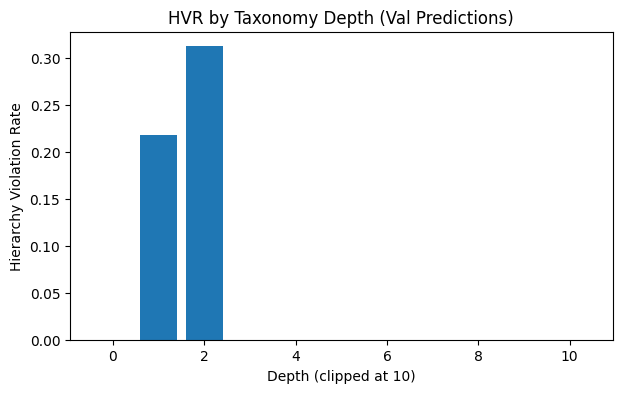

In [27]:
# =========================
# Cell 12: Hierarchy Violation Rate (HVR) - Enhancement 1 compatible
# =========================

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn.functional as F

# -------------------------
# 0) Get predictions from model on val set
# -------------------------
@torch.no_grad()
def predict_label_lists(model, loader, device, thresh=0.5, topk=None):
    """
    Returns: list[list[int]] predicted labels for each sample in loader order.
    You can use either:
      - thresh=0.5 (default) OR
      - topk=int (choose top-k labels per sample)
    """
    model.eval()
    all_preds = []
    for batch in tqdm(loader, desc="Predicting for HVR", leave=False):
        xb = batch["X"].to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).detach().cpu().numpy()

        if topk is not None:
            idx = np.argpartition(-probs, kth=topk-1, axis=1)[:, :topk]
            for row, inds in zip(probs, idx):
                # sort topk indices by prob desc
                inds = inds[np.argsort(-row[inds])]
                all_preds.append(list(map(int, inds)))
        else:
            pred = (probs >= thresh)
            for row in pred:
                all_preds.append(list(np.where(row)[0].astype(int)))

    return all_preds

# NOTE: choose one. For noisy silver, top-k often makes more stable HVR.
THRESH = 0.5
TOPK = None   # e.g., set TOPK=5 if you prefer fixed-size predictions

pred_labels = predict_label_lists(model, val_loader, device=device, thresh=THRESH, topk=TOPK)
print("Pred lists:", len(pred_labels), "| example:", pred_labels[0][:10])

# -------------------------
# 1) Compute depth of each label (for "HVR by depth" plot)
# If DAG has multiple parents, we take MIN depth from any root.
# -------------------------
def compute_depths(num_classes, parents):
    depths = np.full(num_classes, -1, dtype=int)

    # roots: labels with no parents
    roots = [c for c in range(num_classes) if len(parents.get(c, set())) == 0]

    from collections import deque
    q = deque(roots)
    for r in roots:
        depths[r] = 0

    # build children adjacency for BFS
    children = {i: [] for i in range(num_classes)}
    for child, ps in parents.items():
        for p in ps:
            children[p].append(child)

    while q:
        u = q.popleft()
        for v in children[u]:
            nd = depths[u] + 1
            if depths[v] == -1 or nd < depths[v]:
                depths[v] = nd
                q.append(v)

    depths[depths == -1] = 0
    return depths

depths = compute_depths(NUM_CLASSES, parents)

# -------------------------
# 2) HVR computation
# Violation: predicted child label but NONE of its parents are predicted.
# -------------------------
def compute_hvr(pred_labels, parents):
    total_child_preds = 0
    violations = 0

    for labs in pred_labels:
        S = set(labs)
        for c in labs:
            ps = parents.get(c, set())
            if len(ps) == 0:
                continue
            total_child_preds += 1
            if len(S.intersection(ps)) == 0:
                violations += 1

    hvr = violations / max(total_child_preds, 1)
    return hvr, violations, total_child_preds

hvr, v_cnt, child_cnt = compute_hvr(pred_labels, parents)
print(f"HVR = {hvr:.4f}  (violations={v_cnt} / child_preds={child_cnt})")

# -------------------------
# 3) HVR by depth (visual)
# -------------------------
def hvr_by_depth(pred_labels, parents, depths, max_depth=10):
    viol = np.zeros(max_depth+1, dtype=int)
    tot  = np.zeros(max_depth+1, dtype=int)

    for labs in pred_labels:
        S = set(labs)
        for c in labs:
            ps = parents.get(c, set())
            if len(ps) == 0:
                continue
            d = int(min(depths[c], max_depth))
            tot[d] += 1
            if len(S.intersection(ps)) == 0:
                viol[d] += 1

    rate = viol / np.maximum(tot, 1)
    return rate, viol, tot

rate, viol, tot = hvr_by_depth(pred_labels, parents, depths, max_depth=10)

plt.figure(figsize=(7,4))
plt.bar(np.arange(len(rate)), rate)
plt.xlabel("Depth (clipped at 10)")
plt.ylabel("Hierarchy Violation Rate")
plt.title("HVR by Taxonomy Depth (Val Predictions)")
plt.show()


In [21]:
pip install openTSNE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Docs: (1950, 768) | top1 labels: 46
Labels: (531, 768)


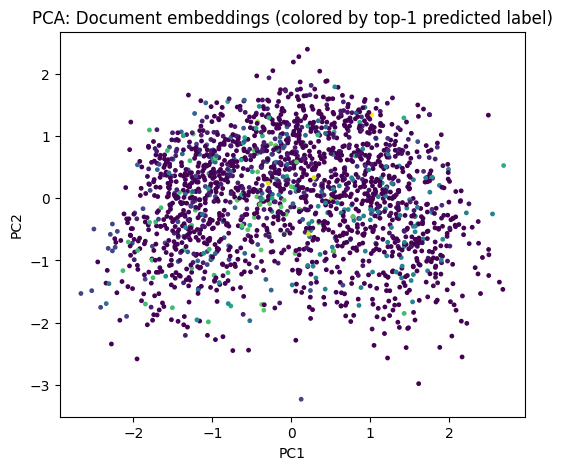

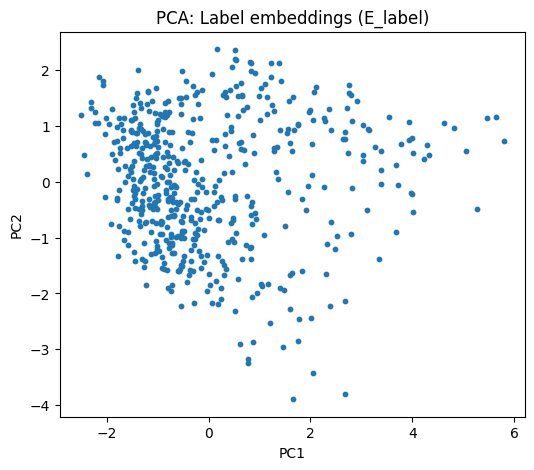

In [29]:
# =========================
# Cell 13: PCA + t-SNE visualization (Docs vs Labels) - Enh1 compatible
# =========================

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -------------------------
# 0) Get predicted top-1 label for each val doc (for coloring)
# -------------------------
@torch.no_grad()
def predict_top1(model, X_np, device="cuda", batch_size=256):
    model.eval()
    top1 = []
    for i in range(0, len(X_np), batch_size):
        xb = torch.tensor(X_np[i:i+batch_size], dtype=torch.float32).to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        top1.extend(list(np.argmax(probs, axis=1).astype(int)))
    return np.array(top1, dtype=int)

# Use validation docs by default
X_docs = X_va
doc_top1 = predict_top1(model, X_docs, device=device, batch_size=256)

print("Docs:", X_docs.shape, "| top1 labels:", len(np.unique(doc_top1)))

# Label embeddings (E_label) should be shape [NUM_CLASSES, d]
E = E_label.detach().cpu().numpy() if torch.is_tensor(E_label) else np.array(E_label)
print("Labels:", E.shape)

# -------------------------
# 1) PCA (Docs)
# -------------------------
pca_docs = PCA(n_components=2, random_state=42)
X_docs_pca = pca_docs.fit_transform(X_docs)

plt.figure(figsize=(6,5))
plt.scatter(X_docs_pca[:,0], X_docs_pca[:,1], s=6, c=doc_top1)
plt.title("PCA: Document embeddings (colored by top-1 predicted label)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# -------------------------
# 2) PCA (Labels)
# -------------------------
pca_lbl = PCA(n_components=2, random_state=42)
E_pca = pca_lbl.fit_transform(E)

plt.figure(figsize=(6,5))
plt.scatter(E_pca[:,0], E_pca[:,1], s=10)
plt.title("PCA: Label embeddings (E_label)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

